In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex
import socket, struct 

pd.set_option('display.max_columns', 500)
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_parquet('merged_simargl.gzip')

In [3]:
print("This dataset has {} columns and {} rows".format(df.shape[1],df.shape[0]))

This dataset has 25 columns and 4901358 rows


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4901358 entries, 0 to 1330691
Data columns (total 25 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   DST_TO_SRC_SECOND_BYTES     object
 1   FLOW_DURATION_MILLISECONDS  int64 
 2   IN_BYTES                    int64 
 3   IN_PKTS                     int64 
 4   IPV4_DST_ADDR               object
 5   IPV4_SRC_ADDR               object
 6   L4_DST_PORT                 int64 
 7   L4_SRC_PORT                 int64 
 8   MAX_IP_PKT_LEN              int64 
 9   MIN_IP_PKT_LEN              int64 
 10  OUT_BYTES                   int64 
 11  OUT_PKTS                    int64 
 12  PROTOCOL                    int64 
 13  PROTOCOL_MAP                object
 14  RETRANSMITTED_IN_BYTES      int64 
 15  RETRANSMITTED_IN_PKTS       int64 
 16  RETRANSMITTED_OUT_BYTES     int64 
 17  RETRANSMITTED_OUT_PKTS      int64 
 18  SRC_TO_DST_SECOND_BYTES     object
 19  TCP_FLAGS                   int64 
 20  TCP_WIN

In [5]:
df.describe(include=[object])

,DST_TO_SRC_SECOND_BYTES,IPV4_DST_ADDR,IPV4_SRC_ADDR,PROTOCOL_MAP,SRC_TO_DST_SECOND_BYTES,L7_PROTO_NAME,Attack
count,4901358,4901358,4901358,4901358,4901358,4901358,4901358
unique,220714,151868,38982,5,232608,411,4
top,40,10.114.226.5,10.114.241.166,tcp,44,Unknown,SYN Scan - aggressive
freq,2168095,434478,2512625,3625011,2524868,2950884,2496814


In [6]:
df.describe()

,FLOW_DURATION_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,MAX_IP_PKT_LEN,MIN_IP_PKT_LEN,OUT_BYTES,OUT_PKTS,PROTOCOL,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_FLAGS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,Label
count,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4901358.0,4901358.0,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06,4.901358e+06
mean,2.274823e+03,6.826010e+03,1.474963e+01,2.062448e+04,4.534470e+04,0.0,0.0,1.986429e+04,1.785704e+01,8.326119e+00,1.367366e+02,1.297324e-01,1.580767e+03,1.110030e+00,1.387824e+01,5.988169e+03,3.564571e+03,5.126067e-01
std,1.283415e+04,2.004935e+06,1.555223e+03,2.192566e+04,1.477386e+04,0.0,0.0,1.705709e+06,1.276004e+03,4.786715e+00,1.934274e+04,1.349416e+01,5.565988e+04,3.831337e+01,1.177566e+01,1.619278e+04,1.282901e+04,4.998411e-01
min,0.000000e+00,2.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.400000e+01,1.000000e+00,4.430000e+02,4.895800e+04,0.0,0.0,4.000000e+01,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,4.400000e+01,1.000000e+00,1.068100e+04,4.947000e+04,0.0,0.0,4.000000e+01,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,1.024000e+03,0.000000e+00,1.000000e+00
75%,2.600000e+01,9.800000e+01,1.000000e+00,4.008800e+04,4.998300e+04,0.0,0.0,1.230000e+02,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,1.024000e+03,0.000000e+00,1.000000e+00
max,1.199990e+05,2.914678e+09,2.087191e+06,6.553500e+04,6.553500e+04,0.0,0.0,2.277959e+09,1.528392e+06,5.800000e+01,1.881421e+07,1.318300e+04,3.511003e+07,2.342900e+04,2.470000e+02,6.553500e+04,6.553500e+04,1.000000e+00


In [7]:
# Can ignore NaN values
df.nunique()

DST_TO_SRC_SECOND_BYTES       220714
FLOW_DURATION_MILLISECONDS     63789
IN_BYTES                       38144
IN_PKTS                         5218
IPV4_DST_ADDR                 151868
IPV4_SRC_ADDR                  38982
L4_DST_PORT                    65536
L4_SRC_PORT                    64258
MAX_IP_PKT_LEN                     1
MIN_IP_PKT_LEN                     1
OUT_BYTES                      45338
OUT_PKTS                        5491
PROTOCOL                           5
PROTOCOL_MAP                       5
RETRANSMITTED_IN_BYTES          2011
RETRANSMITTED_IN_PKTS            438
RETRANSMITTED_OUT_BYTES         5423
RETRANSMITTED_OUT_PKTS          1530
SRC_TO_DST_SECOND_BYTES       232608
TCP_FLAGS                         52
TCP_WIN_MAX_IN                 10270
TCP_WIN_MAX_OUT                 8678
L7_PROTO_NAME                    411
Attack                             4
Label                              2
dtype: int64

In [8]:
df.duplicated().sum()

285750

In [9]:
print("Total de valores nulos")
print(df.isnull().sum())

Total de valores nulos
DST_TO_SRC_SECOND_BYTES       0
FLOW_DURATION_MILLISECONDS    0
IN_BYTES                      0
IN_PKTS                       0
IPV4_DST_ADDR                 0
IPV4_SRC_ADDR                 0
L4_DST_PORT                   0
L4_SRC_PORT                   0
MAX_IP_PKT_LEN                0
MIN_IP_PKT_LEN                0
OUT_BYTES                     0
OUT_PKTS                      0
PROTOCOL                      0
PROTOCOL_MAP                  0
RETRANSMITTED_IN_BYTES        0
RETRANSMITTED_IN_PKTS         0
RETRANSMITTED_OUT_BYTES       0
RETRANSMITTED_OUT_PKTS        0
SRC_TO_DST_SECOND_BYTES       0
TCP_FLAGS                     0
TCP_WIN_MAX_IN                0
TCP_WIN_MAX_OUT               0
L7_PROTO_NAME                 0
Attack                        0
Label                         0
dtype: int64


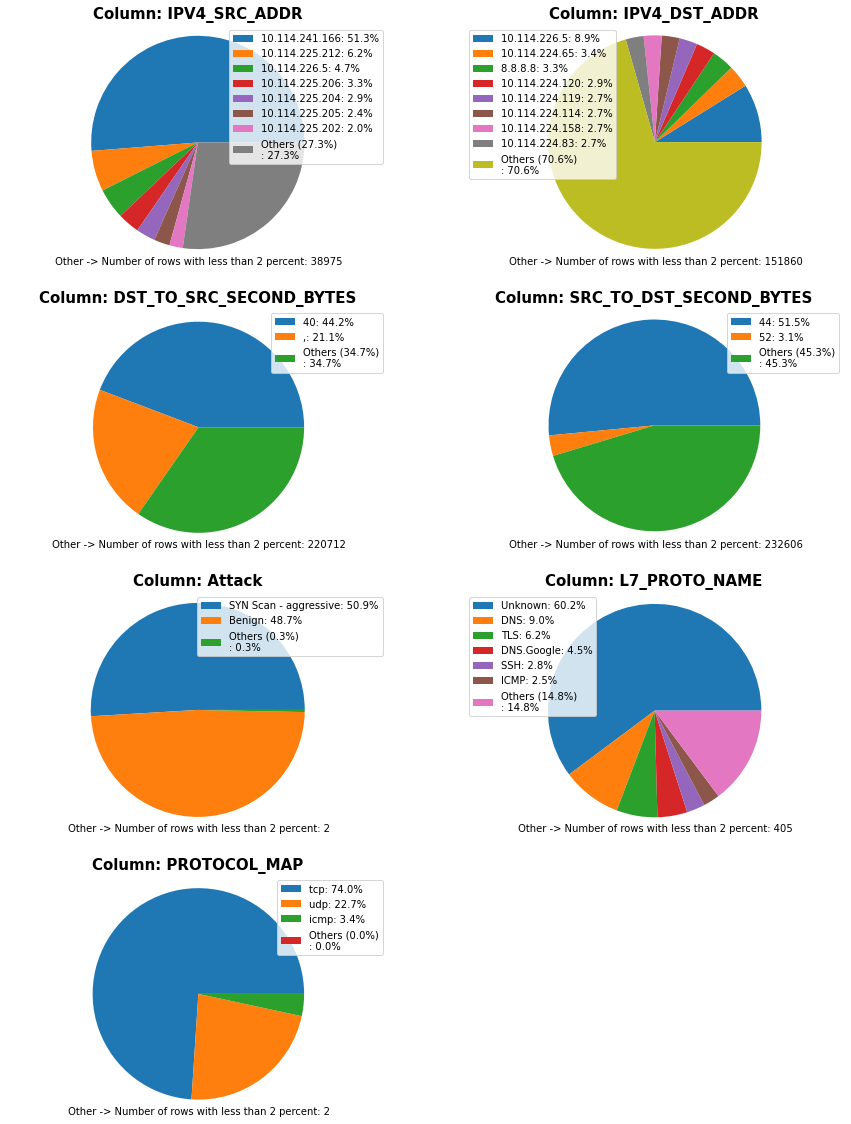

In [10]:
cols = ["IPV4_SRC_ADDR", "IPV4_DST_ADDR", "DST_TO_SRC_SECOND_BYTES","SRC_TO_DST_SECOND_BYTES", "Attack", "L7_PROTO_NAME", "PROTOCOL_MAP"]

fig_nr_columns = 2
fig_nr_rows = 4
fig = plt.figure(1, figsize=[15,20])
percentage = 2

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

In [ ]:
cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS",
        "MIN_IP_PKT_LEN","MAX_IP_PKT_LEN", "SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES", "RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS",
        "TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT", "Label", "PROTOCOL"]

fig_nr_columns = 2
fig_nr_rows = 17
fig = plt.figure(1, figsize=[40,70])

for k in range(len(cols)):
    num_bins = 100
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.hist(df[cols[k]], num_bins)
    plt.title("Column: {}".format(cols[k]), fontweight='bold')
    plt.ylabel("Count")

plt.show()

In [ ]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS",
        "MIN_IP_PKT_LEN","MAX_IP_PKT_LEN", "SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES", "RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS",
        "TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT", "Label", "PROTOCOL"]

fig_nr_columns = 2
fig_nr_rows = 12
c = 0
fig = plt.figure(1, figsize=[25,37])
for k in range(0,24,2):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[c]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[c], yvalues.min(), yvalues.max()), fontweight='bold')
    
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+2)
    yvalues_outliers = yvalues[~is_outlier(yvalues)]
    percenteOutliers = ( 1 - ( len(yvalues_outliers)/len(yvalues) ) ) * 100
    ax.boxplot(yvalues_outliers, vert=False)
    plt.title("{} Without Outliers [{} - {}] - {}%".format(cols[c], yvalues_outliers.min(), yvalues_outliers.max(),round(percenteOutliers,2)), fontweight='bold')
    c += 1
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(data=df, x="L4_SRC_PORT", y="L4_DST_PORT", hue="Attack", ax=ax)